# Segregation Analysis with PySAL

In [1]:
%load_ext watermark

In [2]:
%watermark -v -a "author: eli knaap" -d -u -p segregation,libpysal,geopandas

author: eli knaap 
last updated: 2020-02-15 

CPython 3.7.6
IPython 7.12.0

segregation 1.2.0
libpysal 4.2.2
geopandas 0.6.3


Here, we'll use PySAL's `segregation` module to analyze racial segregation in southern california

In [3]:
import geopandas as gpd

## Data Prep

In [4]:
scag = gpd.read_file("data/scag_region.gpkg", layer="tracts")

We need to reproject the data into a more appropriate coordinate system. UTM11 should work 

In [5]:
scag = scag.to_crs(epsg=26911)
scag.crs

/Users/knaaptime/anaconda3/envs/workshop/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


{'init': 'epsg:26911', 'no_defs': True}

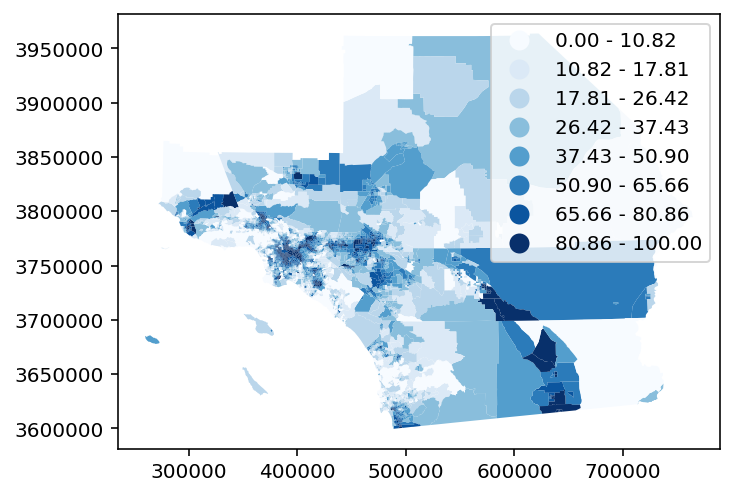

In [6]:
scag.dropna(subset=['p_hispanic_persons']).plot(column='p_hispanic_persons',
                                                scheme='quantiles', 
                                                cmap='Blues',
                                                k=8, 
                                                legend=True)

some background on [fips codes](https://www.policymap.com/2012/08/tips-on-fips-a-quick-guide-to-geographic-place-codes-part-iii/)

In [7]:
scag['county'] = scag.geoid.str[:5]

In [8]:
scag.county.unique()

array(['06037', '06025', '06059', '06071', '06073', '06065', '06111'],
      dtype=object)

In [9]:
county_names = ["Los Angeles", "Imperial", "Orange", "San Bernadino", "San Diego", "Riverside", "Ventura"]

In [10]:
namer = dict(zip(scag.county.unique(), county_names))

In [11]:
namer

{'06037': 'Los Angeles',
 '06025': 'Imperial',
 '06059': 'Orange',
 '06071': 'San Bernadino',
 '06073': 'San Diego',
 '06065': 'Riverside',
 '06111': 'Ventura'}

Now that we know which county is which, we could just use these codes to divide up the region into pieces. But lets go ahead and replace the codes with their names. It's more to type, but if we want to subset later, we won't have to go look up the codes again

In [12]:
scag['county'] = scag.county.replace(to_replace=namer)

In [13]:
scag.county

0       Los Angeles
1       Los Angeles
2       Los Angeles
3       Los Angeles
4       Los Angeles
           ...     
4575    Los Angeles
4576    Los Angeles
4577        Ventura
4578      Riverside
4579    Los Angeles
Name: county, Length: 4580, dtype: object

In [14]:
coastal = scag[scag.county.isin(["Los Angeles", "Orange", "San Diego", "Ventura"])]

In [15]:
inland = scag[scag.county.isin(['Riverside', "San Bernadino", "Imperial"])]

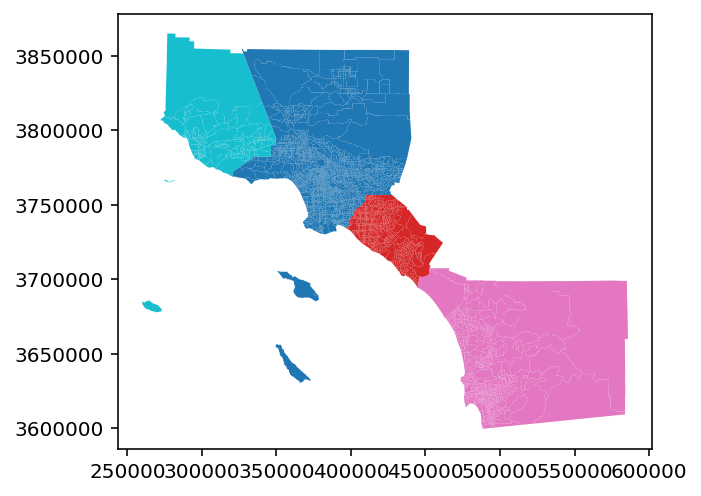

In [16]:
coastal.plot(column='county')

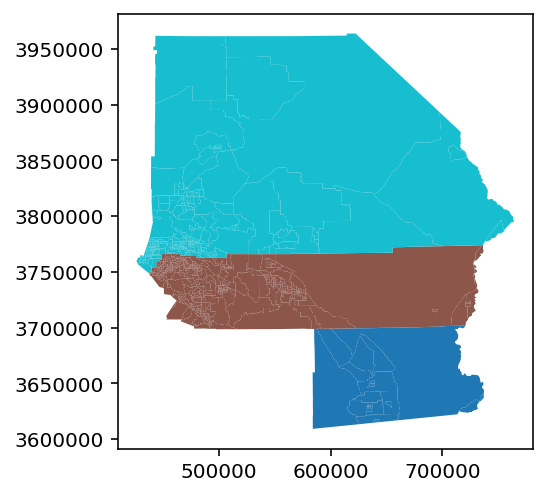

In [17]:
inland.plot(column='county')

## Calculating Segregation Measures

### Classic (aspatial) Single-Group Indices

In [18]:
from segregation.aspatial import Dissim, GiniSeg, Entropy

In [19]:
dissim = Dissim(scag, "n_hispanic_persons", "n_total_pop")
gini = GiniSeg(scag, "n_hispanic_persons", "n_total_pop")
entropy = Entropy(scag, "n_hispanic_persons", "n_total_pop")

In [20]:
dissim.statistic

0.4820197253710138

In [21]:
gini.statistic

0.6368128074464425

In [22]:
entropy.statistic

0.24939370275933018

### Multigroup Indices

In [23]:
from segregation.aspatial import MultiInformationTheory, MultiGiniSeg, MultiDiversity

In [24]:
pop_groups = ['n_asian_persons', 'n_hispanic_persons', 'n_nonhisp_black_persons', 'n_nonhisp_white_persons']

In [25]:
multi_div = MultiDiversity(scag, pop_groups)
multi_info = MultiInformationTheory(scag, pop_groups)

In [26]:
multi_div.statistic

1.1649555024744425

In [27]:
multi_info.statistic

0.27621346024237237

### Spatial Indices

In [28]:
from libpysal import weights

In [29]:
from segregation.spatial import SpatialDissim,  SpatialInformationTheory

In [30]:
w_queen = weights.Queen.from_dataframe(scag)
w_dist = weights.DistanceBand.from_dataframe(scag, 2500)

/Users/knaaptime/anaconda3/envs/workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 4285.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 421 disconnected components.
 There are 362 islands with ids: 157, 159, 162, 163, 164, 165, 209, 243, 245, 276, 344, 405, 415, 437, 447, 457, 481, 482, 484, 489, 490, 492, 518, 774, 873, 907, 908, 963, 970, 971, 972, 973, 1017, 1053, 1055, 1070, 1105, 1118, 1158, 1167, 1209, 1221, 1295, 1374, 1424, 1433, 1435, 1477, 1486, 1492, 1512, 1543, 1544, 1565, 1571, 1572, 1574, 1575, 1583, 1603, 1606, 1611, 1612, 1613, 1628, 1636, 1637, 1639, 1656, 1660, 1661, 1669, 1670, 1679, 1694, 1696, 1698, 1699, 1702, 1719, 1720, 1727, 1729, 1737, 1741, 1743, 1744, 1746, 1757, 1758, 1762

#### Single Group

In [31]:
spatial_dissim = SpatialDissim(scag, 'n_hispanic_persons', 'n_total_pop', w=w_queen)

In [32]:
spatial_dissim.statistic

0.35351598194379474

#### Multi Group

we can also look at how different concepts of space influence the resulting index statistic

In [33]:
spatial_info_queen = SpatialInformationTheory(scag, pop_groups, w=w_queen)
spatial_info_dist = SpatialInformationTheory(scag, pop_groups, w=w_dist)

/Users/knaaptime/anaconda3/envs/workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 421 disconnected components.
  warnings.warn(message)


In [34]:
spatial_info_queen.statistic

0.21447331455751437

In [35]:
spatial_info_dist.statistic

0.2194825382416494

#### Multiscalar Profile

The multiscalar segregation profile is a way of measuring how global versus local the segregation patterns are in a region. 

In [36]:
from segregation.spatial import compute_segregation_profile

In [37]:
distances = [1500., 2500., 3500., 4500., 5500.]

In [38]:
prof = compute_segregation_profile(scag, pop_groups, distances)

/Users/knaaptime/anaconda3/envs/workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 1167 disconnected components.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 258 disconnected components.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 196 disconnected components.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 152 disconnected components.
  warnings.warn(message)


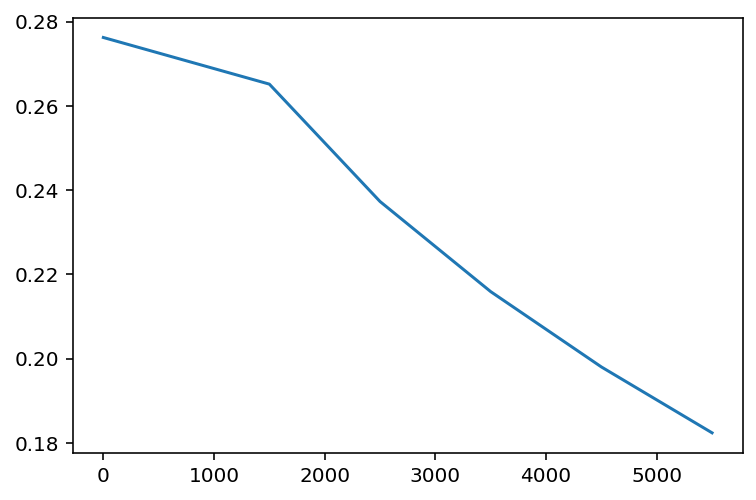

In [39]:
import pandas as pd
pd.Series(prof).plot()

We can also look at how the segregation profiles differ by region. If we plot them all on the same graph, we can compare the slopes of the lines to see how the shape of segregation differs between places in the southern cal region

In [40]:
coastal_prof = compute_segregation_profile(coastal, pop_groups, distances)
inland_prof = compute_segregation_profile(inland, pop_groups, distances)

/Users/knaaptime/anaconda3/envs/workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 660 disconnected components.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 197 disconnected components.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 119 disconnected components.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 85 disconnected components.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: Use

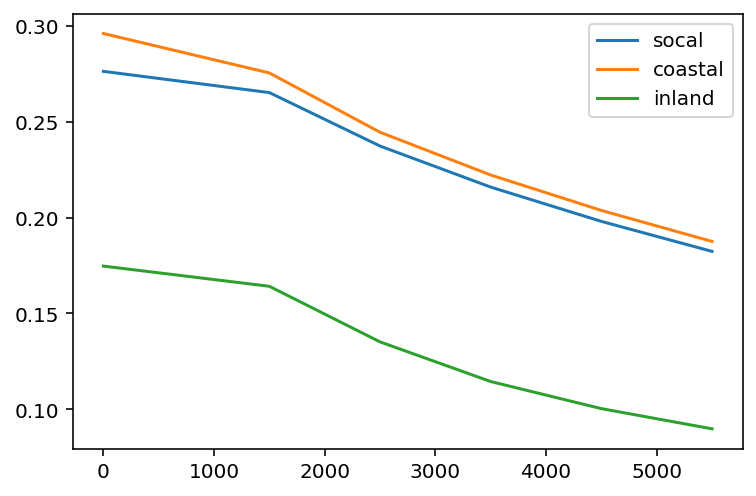

In [41]:

pd.Series(prof, name='socal').plot(legend=True)
pd.Series(coastal_prof, name='coastal').plot(legend=True)
pd.Series(inland_prof, name='inland').plot(legend=True)

This shows that segregation in the coastal region is considerably larger than the inland region at every scale, though have similar shapes to their overall segregation profiles.

## Single-Value Inference

In [42]:
from segregation.inference import SingleValueTest

In [43]:
entropy_test = SingleValueTest(entropy)

In [44]:
dissim_test = SingleValueTest(dissim)

In [45]:
entropy_test.p_value

0.0

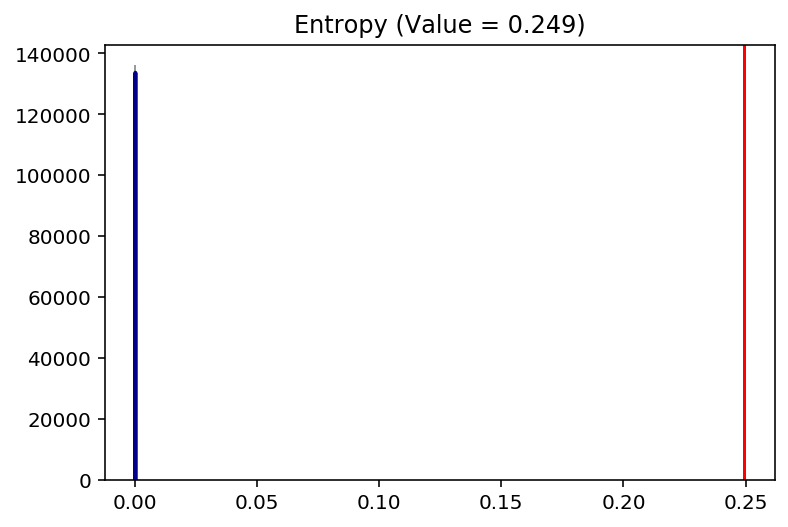

In [46]:
entropy_test.plot()

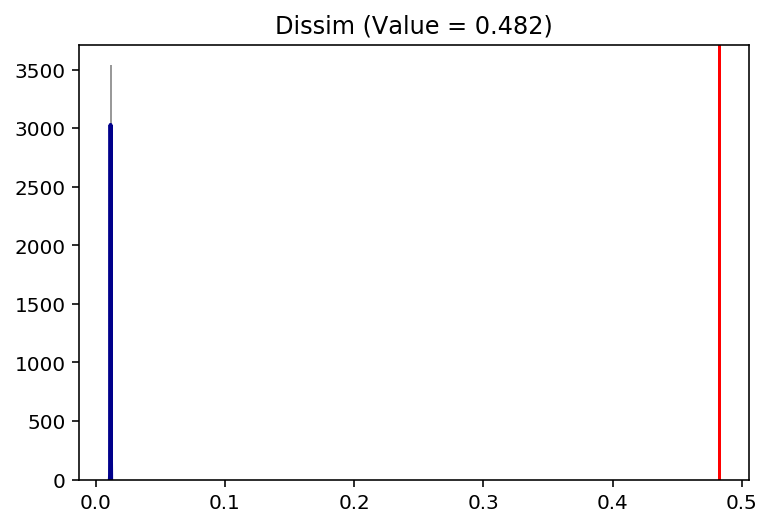

In [47]:
dissim_test.plot()

## Comparative Inference

In [48]:
from segregation.inference import TwoValueTest

In [49]:
info_test = TwoValueTest(MultiInformationTheory(coastal, pop_groups),
            MultiInformationTheory(inland, pop_groups))

In [50]:
info_test.est_point_diff

0.1212617149430146

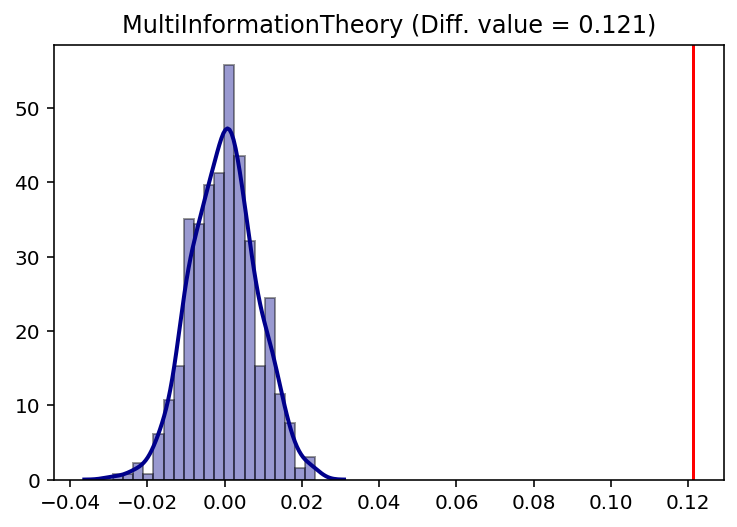

In [51]:
info_test.plot()

## Decomposition

In [52]:
from segregation.decomposition import DecomposeSegregation

In [53]:
w_coastal = weights.DistanceBand.from_dataframe(coastal, 2000)

/Users/knaaptime/anaconda3/envs/workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 304 disconnected components.
 There are 253 islands with ids: 209, 344, 393, 461, 481, 482, 539, 774, 796, 873, 923, 963, 1053, 1055, 1082, 1118, 1141, 1158, 1167, 1209, 1211, 1295, 1374, 1412, 1543, 1544, 1571, 1572, 1583, 1584, 1603, 1611, 1612, 1613, 1621, 1628, 1637, 1639, 1640, 1642, 1656, 1660, 1669, 1670, 1679, 1699, 1727, 1729, 1746, 1757, 1758, 1786, 1813, 1851, 1852, 1856, 1867, 1931, 1933, 1950, 2000, 2012, 2017, 2019, 2021, 2022, 2033, 2035, 2077, 2091, 2119, 2137, 2174, 2175, 2177, 2178, 2185, 2231, 2240, 2242, 2253, 2254, 2260, 2292, 2313, 2330, 2368, 2379, 2388, 2398, 2399, 2414, 2433, 2439, 2443, 2446, 2447, 2462, 2482, 2483, 2485, 2486, 2487, 2488, 2499, 2500, 2501, 2503, 2539, 2540, 2586, 2601, 2604, 2618, 2629, 2642, 2643, 2671, 2672, 2674, 2675, 2678, 2690, 2706, 2725, 2729, 2770, 2784, 2794, 2795, 

In [54]:
w_inland = weights.DistanceBand.from_dataframe(inland, 2000)

/Users/knaaptime/anaconda3/envs/workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 324 disconnected components.
 There are 275 islands with ids: 157, 159, 161, 162, 163, 164, 165, 171, 236, 240, 241, 243, 245, 276, 289, 405, 406, 415, 437, 444, 447, 453, 457, 459, 484, 489, 490, 491, 492, 500, 518, 679, 877, 907, 908, 947, 970, 971, 972, 973, 1017, 1066, 1070, 1105, 1168, 1212, 1221, 1222, 1230, 1390, 1394, 1413, 1424, 1426, 1427, 1433, 1435, 1444, 1477, 1486, 1492, 1512, 1559, 1565, 1574, 1575, 1592, 1605, 1606, 1636, 1661, 1663, 1694, 1696, 1697, 1698, 1702, 1719, 1720, 1737, 1738, 1741, 1743, 1744, 1762, 1763, 1764, 1782, 1784, 1794, 1800, 1805, 1807, 1861, 1863, 1873, 1876, 1879, 1892, 1954, 1955, 1956, 1957, 1959, 1963, 1964, 1965, 1966, 1993, 2004, 2005, 2024, 2027, 2029, 2282, 2312, 2318, 2319, 2320, 2321, 2331, 2334, 2337, 2338, 2339, 2341, 2342, 2359, 2375, 2418, 2419, 2420, 2429, 2430, 2444

In [55]:
decomp = DecomposeSegregation(SpatialDissim(coastal, 'n_nonhisp_black_persons', 'n_total_pop', w=w_coastal),
                    SpatialDissim(inland,'n_nonhisp_black_persons', 'n_total_pop', w=w_inland))

/Users/knaaptime/anaconda3/envs/workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 3502.
  warnings.warn(message)


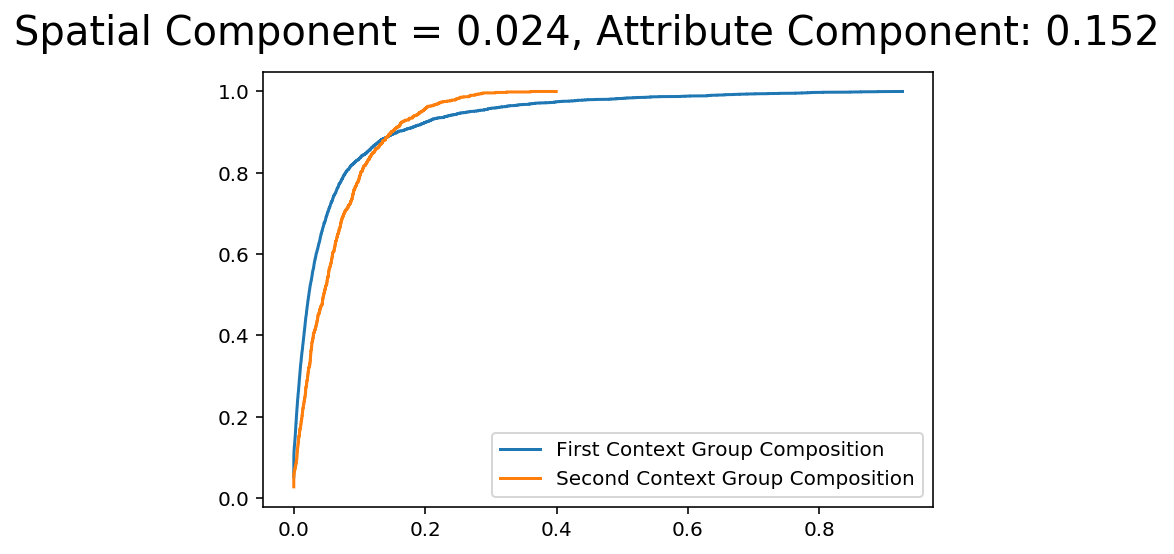

In [56]:
decomp.plot()

## Exercise

1. Which county in the socal region has the greatest level of multiracial segregation, (using the 4 categories above) according to the MultiInformationTheory index?

2. According to the Gini index, is hispanic/latino segregation in Riverside County greater or less than Ventura County? Is that difference significant?

3. According to the Spatial Dissimilarity index, does the difference in segregation between Riverside and Venture result from the demograpic structure or the spatial structure?